# Optimal Level Control 
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
## Problem Statement and Model
------------------------------------------------------------------------------------------------
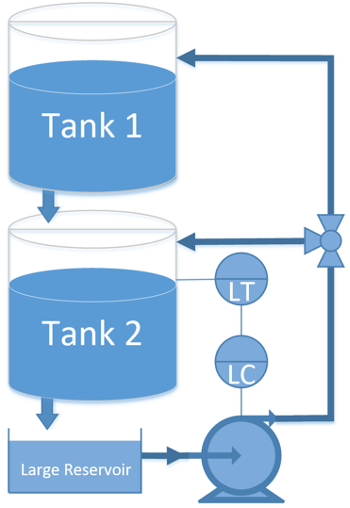

In this simple example, we will be determining an optimal strategy for controlling pump rate and valve position to minimize the deviation of the height in tank 2, shown in the figure above, from its set point. The pump is capable of sending fluid to each of the two tanks due to the three-way valve depicted in the figure. Furthermore, by assuming that the flow out of each tank is proportional to the liquid level, the quadratic optimization problem may be expressed by the following model (Note: This problem was adapted from http://apmonitor.com/do/index.php/Main/LevelControl):


$$
\begin{aligned}
\min_{p(t),\ \nu(t)} &&& \int_{0}^{600}{(h_2(t)-h_{2, set}(t))^2dt}\\
\\
\text{s.t.} &&&  \frac{d h_1(t) }{dt} = C_1 \nu(t) p(t) - C_2 h_1(t), && \forall \ t \in [0, \ 600] \\
&&& \frac{d h_2(t) }{dt} = C_3 h_1(t) + C_4 (1 - \nu(t)) p(t) - C_5 h_2(t), && \forall \ t \in [0, \ 600] \\
\\
&&&  0 \le h_1(t) \le 2, && \forall \ t \in [0, \ 600] \\
&&&  0 \le h_2(t) \le 2, && \forall \ t \in [0, \ 600] \\
&&&  0 \le p(t) \le 1, && \forall \ t \in [0, \ 600] \\
&&&  0 \le \nu(t) \le 1, && \forall \ t \in [0, \ 600] \\
\\
&&& h_1(0) = 0 \\
&&& h_2(0) = 0 \\
&&& p(0) = 0 \\
&&& \nu (0) = 0 \\
\end{aligned}
$$


In this model, $t$, $h_1(t)$, $h_2(t)$,  $p(t)$, and $\nu(t)$ are time, liquid level in tank 1, liquid level in tank 2, pump rate, and valve position. Along with this, $C_{1-5}$ are system parameters that capture the physics of the problem and the characteristics of each tank. Furthermore, the following constant, piecewise function for the set point of tank 2 will be used to demonstrate how the system responds to multiple changes in set point.

$$
\begin{aligned}
&&& h_{2, set}(t) = 
\begin{cases} 
      0.8, & 0 \le t \leq 100 \\
      0.6, & 100 < t \leq 200 \\
      0.9, & 200 < t \leq 300 \\
      0.4, & 300 < t \leq 400 \\
      0.8, & 400 < t \leq 600 \\
\end{cases}
\end{aligned}
$$

## Modeling Preliminaries
----------------------------------------------------------------------------------------------
Now equipped with a model for this system, we can determine how to control the pump rate and valve position to minimize the deviation from the set point in tank 2 using `InfiniteOpt.jl`. To do this, we start by loading in the required packages and defining the system parameters.  

In [1]:
# Load required packages
using InfiniteOpt, Ipopt, Plots

In [2]:
# Define the system parameters 
C_1 = 0.07; C_2 = 0.05; C_3 = 0.04; C_4 = 0.05; C_5 = 0.04;

## Model Initialization
----------------------------------------------------------------------------------------------
With our basic parameters defined, we can now initialize the model using `@InfiniteModel`. Here, we choose to use Ipopt optimizer because it is capable of optimizing quadratic models, which is the case for this system.

In [3]:
# Initialize the model
m = InfiniteModel(Ipopt.Optimizer);

## Parameter and Variable Definition
----------------------------------------------------------------------------------------------
We now can define the infinite parameter and declare the infinite variables. For this model, we have one infinite parameter, time ($t \in [0, \ 600]$). Furthermore, we have two control variables and two output variables, which are defined below.

Control Variables:

\begin{aligned}
&&& p(t) \in [0, 1] , && \forall \ t \in [0, \ 600] \\
&&& \nu(t) \in [0, 1], && \forall \ t \in [0, \ 600] \\
\end{aligned}

Output Variables: 

\begin{aligned}
&&& h_1(t) \in [0, 2], && \forall \ t \in [0, \ 600] \\
&&& h_2(t) \in [0, 2], && \forall \ t \in [0, \ 600] \\
\end{aligned}

To define the infinite parameters and variables in `InfiniteOpt.jl`, we can use `@infinite_parameter` and `@variable`, respectively.

In [4]:
# Define time as the infinite parameter
@infinite_parameter(m, t in [0, 600], num_supports = 100, derivative_method = OrthogonalCollocation(4))

t

Notice that in the definition of the infinite parameter we specify the number of supports, which discretizes the time horizon into 100 points for this system. Along with this, when the model contains differential equations, it is useful to choose a derivative method that best suits the application. In this case, we use orthogonal collocation, but the documentation page contains more information on the different derivative methods available.

In [5]:
# Define the infinite variables
# Control Variables
@variable(m, 0 ≤ p ≤ 1, Infinite(t), start = 0)
@variable(m, 0 ≤ ν ≤ 1, Infinite(t), start = 0)
# Output variables
@variable(m, 0 ≤ h_1 ≤ 2, Infinite(t), start = 0)
@variable(m, 0 ≤ h_2 ≤ 2, Infinite(t), start = 0)

h_2(t)

After defining the infinite variables, we are ready to move forward, but it should be noted that in the definition of these variables, the start values are merely initial guesses for the solver and not initial conditions. The initial conditions for this problem will be specified in the next section.

## Constraint Definition
----------------------------------------------------------------------------------------------
Next, we must define the initial conditions and set the constraints within `InfiniteOpt.jl`. This problem has initial conditions for each control and output variable and has two constraints, which are differential equations.

Initial Conditions:

\begin{aligned}
&&& h_1(0) = 0 \\
&&& h_2(0) = 0 \\
&&& p(0) = 0 \\
&&& \nu (0) = 0 \\
\end{aligned}

Constraints:

\begin{aligned}
&&&  \frac{d h_1(t) }{dt} = C_1 \nu(t) p(t) - C_2 h_1(t), && \forall \ t \in [0, \ 600] \\
&&& \frac{d h_2(t) }{dt} = C_3 h_1(t) + C_4 (1 - \nu(t)) p(t) - C_5 h_2(t) , && \forall \ t \in [0, \ 600] \\
\end{aligned}

To implement the initial conditions into the model, we can use `@constraint` with point variables to set the infinite variables to their initial values. Setting the constraints can be done using `@constraint`. Within this definition, `∂` is used for establishing differentials. 

In [6]:
# Define initial conditions using bounded constraints
@constraint(m, h_1(0) == 0)
@constraint(m, h_2(0) == 0)
@constraint(m, p(0) == 0)
@constraint(m, ν(0) == 0)

ν(t) = 0.0, ∀ t = 0

In [7]:
# Define constraints
@constraint(m, ∂(h_1, t) == C_1 * ν * p - C_2 * h_1)
@constraint(m, ∂(h_2, t) == C_3 * h_1 + C_4 * (1 - ν) * p - C_5 * h_2)

0.05 p(t)*ν(t) + ∂/∂t[h_2(t)] - 0.04 h_1(t) - 0.05 p(t) + 0.04 h_2(t) = 0.0, ∀ t ∈ [0, 600]

## Set Point (Parameter Function) Definition
----------------------------------------------------------------------------------------------
Before defining the objective function, we must first create our set point, which is a constant, piecewise function of the infinite parameter, time:

$$
h_{2, set}(t) = 
\begin{cases} 
      0.8, & 0 \le t \leq 100 \\
      0.6, & 100 < t \leq 200 \\
      0.9, & 200 < t \leq 300 \\
      0.4, & 300 < t \leq 400 \\
      0.8, & 400 < t \leq 600 \\
\end{cases}
$$

This expression can be written as a general function within Julia and implemented into `InfiniteOpt.jl` using `@parameter_function`.

In [8]:
# Define the set point as a constant, piece-wise function of various set points
function set_point_function(time)
    if 0 ≤ time ≤ 100
        return 0.8
    elseif 100 < time ≤ 200
        return 0.6
    elseif 200 < time ≤ 300
        return 0.9
    elseif 300 < time ≤ 400
        return 0.4
    elseif 400 < time ≤ 600
        return 0.8
    end
end

# Input the set point as a pre-specified parameter function
h_2_set = parameter_function(set_point_function, t)

set_point_function(t)

## Objective Definition and Optimization
----------------------------------------------------------------------------------------------
Finally, we can define our objective function ($\min \ \int_{0}^{600}{(h_2(t)-h_{2, set}(t))^2dt}$) using `@objective` and optimize the model using `@optimize!`.

In [9]:
# Define the objective function to minimize deviation from our set point
@objective(m, Min, ∫((h_2 - h_2_set) ^ 2, t))

∫{t ∈ [0, 600]}[h_2(t)² - 2 set_point_function(t)*h_2(t) + set_point_function(t)²]

In [10]:
# Optimize the model
optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     5954
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      894

Total number of variables............................:     1788
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1192
                     variables with only upper bounds:        0
Total number of equ

## Extracting the Results
----------------------------------------------------------------------------------------------
Having found an optimal solution, we are prepared to extract the results for the infinite parameter and variables using `supports` and `value`.

In [11]:
# Extract the results for our optimal control profile
time_plot = supports(t);
pump_speed = value(p);
valve_position = value(ν);
height_2 = value(h_2);

Furthermore, we can conclude this example by creating a plot of our control profiles as well as a plot of $h_2(t)$ in comparison to $h_{2, set}(t)$ to visualize the performance of our controller! 

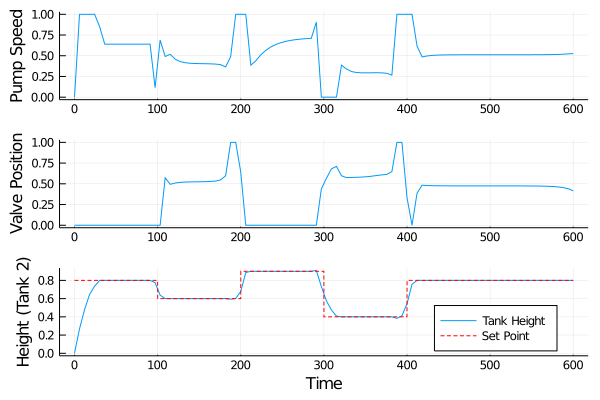

In [12]:
# Create a set point vector to analyze the performance of the system
time_set = 0:0.1:600
h_set_point = zeros(size(time_set))
for i = 1:length(time_set)
    h_set_point[i] = set_point_function(time_set[i])
end

# Plot the results
p_1 = plot(time_plot, pump_speed, xaxis = "", yaxis = "Pump Speed", legend = false)
p_2 = plot(time_plot, valve_position, xaxis = "", yaxis = "Valve Position", legend = false)
p_3 = plot(time_plot, height_2, xaxis = "Time", yaxis = "Height (Tank 2)", labels = "Tank Height")
p_3 = plot!(time_set, h_set_point, labels = "Set Point", legend = (0.80, 0.40), line = :dash, color = :red)
plot(p_1, p_2, p_3, layout = (3, 1))